In [ ]:
%cd '/content/drive/MyDrive/ecehw/project'

/content/drive/MyDrive/ecehw/project


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

from resnet import ResNet18, MLP, Block

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [ ]:
BATCH_SIZE = 256

trainset = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = BATCH_SIZE, shuffle=True, )

Files already downloaded and verified


In [ ]:
def get_color_distortion(s:float=0.5):
    """
    Function from the paper that create color distortion 
    s: float, the strength of color distortion, for CIFAR 10, the paper use 0.5
    """
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

In [ ]:
train_transform = transforms.Compose([
            # make sure we're using PIL instead of tensor when doing other transform 
            transforms.ToPILImage(),
            #transforms.GaussianBlur(23, sigma=(0.1, 2.0)), # CIFAR 10 doesn't use gaussian blur
            transforms.RandomResizedCrop(size=32,scale=(0.08,0.1),ratio=(0.75,1.33)),
            transforms.RandomHorizontalFlip(p=0.5),
            get_color_distortion(),
            transforms.ToTensor(),])

In [ ]:
LR = 1.0

net_f = ResNet18(3, Block)
net_g = MLP(512)
net = nn.Sequential(net_f, net_g)
# optimizer = optim.Adam(net.parameters())
optimizer = optim.SGD(net.parameters(), lr=LR)
net.to(device)
net.train()

Sequential(
  (0): ResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (identity): Sequential()
      )
      (1): Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [ ]:
def compute_loss(yhat, t):
    """
    Computing the contrastive loss based on cosine similarity
    input:
        yhat: [tensor] latent embedding features size: BATCH_SIZE * 128
        t: [float] temperature range: (0.0, 1.0)
    output:
        loss: [tensor] 1D
    """
    
    # testing code
    #from collections import defaultdict
    #cache = defaultdict(int)
    #for i in range(yhat.shape[0]):
    #    for j in range(i+1, yhat.shape[0]):
    #        val = torch.nn.functional.cosine_similarity(yhat[i], yhat[j], dim=0, eps=1e-8)
    #        cache[(i, j)] = val
    #        cache[(j, i)] = val

    # Calculate the pair-wise consine similarity
    cache = torch.nn.functional.cosine_similarity(yhat.unsqueeze(0), yhat.unsqueeze(1), dim=-1, eps=1e-8)
    cache = torch.exp(cache / t)

    # Compute the contrastive loss
    loss = 0
    for n in range(yhat.shape[0]):
        # Get the index of positive pairs, based on 2 tensors of the same pair are adjacent in terms of index
        i = n
        if i % 2 == 0:
            j = i + 1
        else:
            j = i - 1

        # The numerator is between the positive pair
        # The denominator is between one tensor with all OTHER tensors
        numerator = cache[i, j]
        denominator = 10 ** (-8)
        for k in range(yhat.shape[0]):
            if k != i:
                denominator += cache[i, k]
        cur_loss = (-1) * torch.log(numerator / denominator)
        # Add up the loss and take the average
        loss += (1 / 2 * yhat.shape[0]) * cur_loss
    loss = torch.tensor(loss.item())
    loss.requires_grad = True
    # loss = torch.mean(loss)
    return loss

In [ ]:
# loop through each batch in trainset 
LOSSES = []
EPOCHS = 10

for epoch in range(EPOCHS):
    cost = 0
    for data, label in trainset:
        for ind_img in range(len(data)): # loop through each image in batch 
            par_tensor = data[ind_img]
            cur_tensor_0 = train_transform(par_tensor) # first aug
            cur_tensor_1 = train_transform(par_tensor) # second aug 
            # resize 
            cur_tensor_0, cur_tensor_1 = torch.unsqueeze(cur_tensor_0, 0), torch.unsqueeze(cur_tensor_1, 0) 
            # if this is the first image in the batch, we just concat the 2 data aug 
            if ind_img == 0:
                total_tensor = torch.cat((cur_tensor_0, cur_tensor_1), dim=0)
            # else append to the previous augmented pair in the batch 
            else:
                total_tensor = torch.cat((total_tensor, cur_tensor_0, cur_tensor_1), dim=0)
            
        total_tensor = total_tensor.to(device)
        # pass <total_tensor> into the model 
        yhat = net(total_tensor)
        # calculate loss 
        loss = compute_loss(yhat, 0.5)
        ### if ind % 2 == 0: j = ind + 1
        ### 
        
        loss.backward()
        optimizer.step()
        cost += loss.item()
    LOSSES.append(cost)
    print(LOSSES)
        

[158845370.5234375]
[158845370.5234375, 158844939.11328125]
[158845370.5234375, 158844939.11328125, 158845836.48046875]
[158845370.5234375, 158844939.11328125, 158845836.48046875, 158858793.78515625]
[158845370.5234375, 158844939.11328125, 158845836.48046875, 158858793.78515625, 158847383.02734375]
[158845370.5234375, 158844939.11328125, 158845836.48046875, 158858793.78515625, 158847383.02734375, 158854768.1171875]
[158845370.5234375, 158844939.11328125, 158845836.48046875, 158858793.78515625, 158847383.02734375, 158854768.1171875, 158862798.234375]
[158845370.5234375, 158844939.11328125, 158845836.48046875, 158858793.78515625, 158847383.02734375, 158854768.1171875, 158862798.234375, 158831201.50390625]
[158845370.5234375, 158844939.11328125, 158845836.48046875, 158858793.78515625, 158847383.02734375, 158854768.1171875, 158862798.234375, 158831201.50390625, 158841741.85546875]
[158845370.5234375, 158844939.11328125, 158845836.48046875, 158858793.78515625, 158847383.02734375, 158854768.

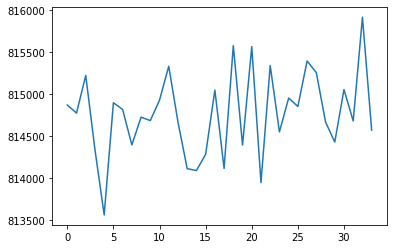

In [ ]:
plt.plot([_ for _ in range(len(LOSSES))], LOSSES)

In [ ]:
# loop through each batch in trainset 
LOSSES = []
#net_f.eval()
temp = []

for data, label in trainset:
    pass